In [2]:
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
# from __future__ import print_function

In [3]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

Let's use the tfidf vectorizer, commonly used for text.

In [4]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

Now, let's say we want to use random forests for classification. It's usually hard to understand what random forests are doing, especially with many trees.

In [5]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

RandomForestClassifier(n_estimators=500)

In [6]:
pred = rf.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary')

0.9241540256709451

# Explaining predictions using LIME

In [7]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

In [8]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [9]:
print(c.predict_proba([newsgroups_test.data[0]]))


[[0.286 0.714]]


now we generate an explainer object - passing class_names as an argument for prettier display

In [10]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

We then generate an explanation with at most 6 features for an arbitrary document in the test set.

In [13]:
idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Document text: ', newsgroups_test.data[idx])
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

Document id: 83
Document text:  From: johnchad@triton.unm.edu (jchadwic)
Subject: Another request for Darwin Fish
Organization: University of New Mexico, Albuquerque
Lines: 11
NNTP-Posting-Host: triton.unm.edu

Hello Gang,

There have been some notes recently asking where to obtain the DARWIN fish.
This is the same question I have and I have not seen an answer on the
net. If anyone has a contact please post on the net or email me.

Thanks,

john chadwick
johnchad@triton.unm.edu
or

Probability(christian) = 0.424
True class: atheism


The classifier got this example right (it predicted atheism).
The explanation is presented below as a list of weighted features.

In [12]:
exp.as_list()

[('Posting', -0.14959992921816997),
 ('Host', -0.14700971819949632),
 ('NNTP', -0.11366160853868154),
 ('edu', -0.023370239233738942),
 ('University', 0.0158015534978094),
 ('There', -0.014439113671873637)]

These weighted features are a linear model, which approximates the behaviour of the random forest classifier in the vicinity of the test example. Roughly, if we remove 'Posting' and 'Host' from the document , the prediction should move towards the opposite class (Christianity) by about 0.27 (the sum of the weights for both features). Let's see if this is the case

In [14]:
print('Original prediction:', rf.predict_proba(test_vectors[idx])[0,1])
tmp = test_vectors[idx].copy()
tmp[0,vectorizer.vocabulary_['Posting']] = 0
tmp[0,vectorizer.vocabulary_['Host']] = 0
print('Prediction removing some features:', rf.predict_proba(tmp)[0,1])
print('Difference:', rf.predict_proba(tmp)[0,1] - rf.predict_proba(test_vectors[idx])[0,1])

Original prediction: 0.424
Prediction removing some features: 0.708
Difference: 0.284


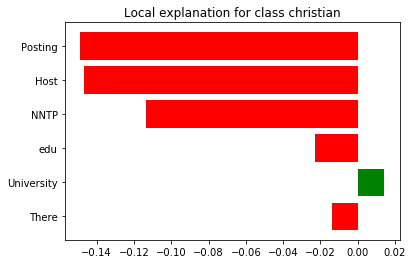

In [15]:
%matplotlib inline
fig = exp.as_pyplot_figure()